In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import matplotlib.pyplot as plt
import joblib

Importing plotly failed. Interactive plots will not work.


In [2]:
# Function to load datasets
def load_data():
    sales_train_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/sales_train.csv')
    calendar_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/calendar.csv')
    calendar_events_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/calendar_events.csv')
    sales_test_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/sales_test.csv')
    items_weekly_sales_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/items_weekly_sell_prices.csv')
    
    print("Datasets loaded successfully.")
    return sales_train_df, calendar_df, calendar_events_df, sales_test_df, items_weekly_sales_df

In [3]:
# Function to preprocess and merge datasets
def preprocess_data(sales_train_df, calendar_df, calendar_events_df, items_weekly_sales_df):
    # Melt sales data
    sales_train_melted = pd.melt(
        sales_train_df,
        id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
        var_name='d',
        value_name='sales'
    )
    
    # Merge with calendar data
    sales_train_merged = pd.merge(sales_train_melted, calendar_df, how='left', on='d')

    # Merge with event data
    sales_train_with_events = pd.merge(sales_train_merged, calendar_events_df, how='left', on='date')

    # Merge with item prices
    sales_train_with_prices = pd.merge(sales_train_with_events, items_weekly_sales_df, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])

    # Fill missing event names and types
    sales_train_with_prices['event_name'].fillna('No Event', inplace=True)
    sales_train_with_prices['event_type'].fillna('None', inplace=True)

    # Forward-fill missing prices
    sales_train_with_prices['sell_price'].fillna(method='ffill', inplace=True)
    sales_train_with_prices['sell_price'].fillna(
        sales_train_with_prices.groupby('item_id')['sell_price'].transform('mean'), 
        inplace=True
    )

    print("Data preprocessed successfully.")
    return sales_train_with_prices

In [4]:
# Function to create features
def create_features(sales_train_with_prices):
    # Convert 'date' to datetime
    sales_train_with_prices['date'] = pd.to_datetime(sales_train_with_prices['date'])

    # Create date-based features
    sales_train_with_prices['day'] = sales_train_with_prices['date'].dt.day
    sales_train_with_prices['month'] = sales_train_with_prices['date'].dt.month
    sales_train_with_prices['weekday'] = sales_train_with_prices['date'].dt.weekday

    # Label encoding
    encoder_store = LabelEncoder()
    encoder_item = LabelEncoder()
    sales_train_with_prices['store_id'] = encoder_store.fit_transform(sales_train_with_prices['store_id'])
    sales_train_with_prices['item_id'] = encoder_item.fit_transform(sales_train_with_prices['item_id'])

    # Initialize label encoders for event names and types
    le_event_name = LabelEncoder()
    le_event_type = LabelEncoder()
    sales_train_with_prices['event_name_encoded'] = le_event_name.fit_transform(sales_train_with_prices['event_name'])
    sales_train_with_prices['event_type_encoded'] = le_event_type.fit_transform(sales_train_with_prices['event_type'])

    print("Features created successfully.")
    return sales_train_with_prices, encoder_store, encoder_item, le_event_name, le_event_type

In [5]:
# Function to aggregate daily sales across all stores and items for Prophet
def aggregate_sales(sales_train_with_prices):
    # Aggregate total daily sales
    sales_data = sales_train_with_prices.groupby('date').agg({'sales': 'sum'}).reset_index()

    # Rename columns to match Prophet's expected format
    sales_data.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
    
    print("Sales data aggregated successfully.")
    return sales_data

In [6]:
# Function to train ARIMA model
def train_arima(sales_data):
    # Convert the aggregated sales data into a time series
    sales_series = sales_data.set_index('ds')['y']
    
    # Train ARIMA model (ARIMA(5, 1, 0) as an example, modify parameters as needed)
    arima_model = ARIMA(sales_series, order=(5, 1, 0))
    arima_result = arima_model.fit()
    
    # Save the ARIMA model using joblib
    #joblib.dump(arima_result, '/Users/bananavodka/Projects/at2_mla/at2_mla/models/forecasting/ARIMA_model.pkl')
    #print("ARIMA model saved successfully.")
    
    return arima_result

In [7]:
# Function to forecast using ARIMA model
def forecast_arima(arima_model, periods=7):
    forecast = arima_model.forecast(steps=periods)
    
    # Create future dates for the forecast
    last_date = arima_model.data.dates[-1]
    future_dates = pd.date_range(last_date, periods=periods+1, freq='D')[1:]
    
    # Plot the forecast
    plt.figure(figsize=(10,6))
    plt.plot(forecast.index, forecast, label='Forecast')
    plt.title("ARIMA Forecast")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()
    
    forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_Sales': forecast})
    print("ARIMA Forecast generated successfully.")
    return forecast_df

Datasets loaded successfully.
Data preprocessed successfully.
Features created successfully.
Sales data aggregated successfully.


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA model saved successfully.


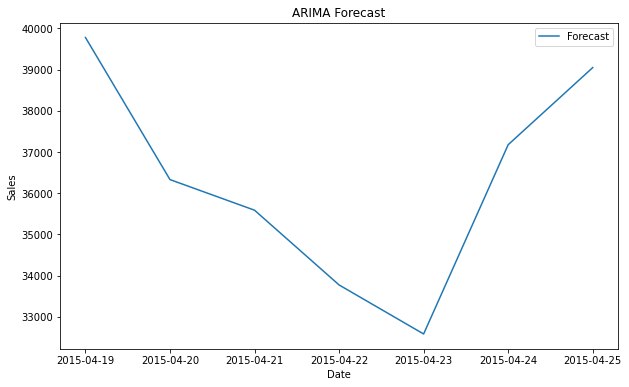

ARIMA Forecast generated successfully.
                 Date  Forecasted_Sales
2015-04-19 2015-04-19      39778.550864
2015-04-20 2015-04-20      36329.955542
2015-04-21 2015-04-21      35587.483480
2015-04-22 2015-04-22      33773.875764
2015-04-23 2015-04-23      32584.160338
2015-04-24 2015-04-24      37176.035216
2015-04-25 2015-04-25      39047.239653


In [8]:
def main():
    # Load datasets
    sales_train_df, calendar_df, calendar_events_df, sales_test_df, items_weekly_sales_df = load_data()

    # Preprocess data
    sales_train_with_prices = preprocess_data(sales_train_df, calendar_df, calendar_events_df, items_weekly_sales_df)

    # Create features
    # Only capture the first value (the DataFrame) from the create_features function
    sales_train_with_prices, _, _, _, _ = create_features(sales_train_with_prices)

    # Aggregate daily sales for Prophet/ARIMA
    sales_data = aggregate_sales(sales_train_with_prices)

    # Train ARIMA model
    arima_model = train_arima(sales_data)

    # Forecast using ARIMA for the next 7 days
    arima_forecast = forecast_arima(arima_model, periods=7)

    # Display forecasted values
    print(arima_forecast)

if __name__ == "__main__":
    main()
